# SphereNN Interpretability Analysis

## Loading dependencies, data and model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow.keras as keras
from deep_dss.helpers import *
import warnings

warnings.filterwarnings(action='once')

# Run on GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# Defaults
plt.rcParams.update({
'lines.color':'black',
'font.family':'serif',
'font.weight':'normal',
'text.color':'black',
'text.usetex': True,
'axes.edgecolor':'black',
'axes.linewidth':1.0,
'axes.titlesize':'x-large',
'axes.labelsize':'x-large',
'axes.labelcolor':'black',
'xtick.labelsize':'x-large',
'xtick.minor.width':1.0,
'xtick.major.width':1.0,
'ytick.major.size':7,
'ytick.minor.size':4,
'ytick.major.pad':8,
'ytick.minor.pad':8,
'ytick.labelsize':'x-large',
'ytick.minor.width':1.0,
'ytick.major.width':1.0,
'legend.numpoints':1,
'legend.fontsize':'x-large',
'legend.shadow':False,
'legend.frameon':False})

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
config = "k"
channels = 1
noiseless_m = False
noiseless_kg = False
free_bias = False
gaussian = False

order = 2
nside = 1024

val_set = "TEST"

exp_name = "spherenn-v3-simple-noisy-fixed-kappa"
num_id = 2
checkpoint_path = "../checkpoints/spherenn/{0}/{0}-{1}".format(exp_name, num_id)
checkpoint_dir = "../checkpoints/spherenn/{0}".format(exp_name)
# !mkdir $checkpoint_dir
log_dir = "../log/{0}".format(exp_name)
# !mkdir $log_dir
fig_dir = "../figures/{0}".format(exp_name)
# !mkdir $fig_dir

In [5]:
def num_cosmologies(dataset):
    if dataset == "TRAINLITE":
        return 16
    if dataset == "TESTLITE":
        return 4
    if dataset == "TEST":
        return 21
    return 45

def generate_reshaped_data(dataset):
    print("Generating data for {0}!".format(dataset))
    num_cosmos = num_cosmologies(dataset)
    data = split_count_and_lensing_maps_by_dataset(dataset, config=config, noiseless_m=noiseless_m,
                                                  noiseless_kg=noiseless_kg, free_bias=free_bias, gaussian=gaussian)
    data["x"] = np.reshape(data["x"], (12*(order**2)*num_cosmos, (nside//order)**2, channels))
    data["y"] = np.reshape(data["y"], (12*(order**2)*num_cosmos, 1, 1))
    return data

In [6]:
def build_model():
    return keras.Sequential([
        keras.Input(shape=(262144, channels)),
        keras.layers.Conv1D(64, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(128, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(256, 4, strides=4, activation='relu'),
        keras.layers.Conv1D(1, 4, strides=4, activation='relu'),
    ])

def load_model():
    model = build_model()
    model.load_weights(checkpoint_path+"-Q4")
    return model

In [7]:
model = load_model()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 65536, 64)         320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16384, 128)        32896     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4096, 256)         131328    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 256)         262400    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 256, 256)          262400    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 64, 256)           262400    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 16, 256)           2

In [9]:
data = generate_reshaped_data("TEST")

Generating data for TEST!


/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site

## Gradient Calculation: Example

In [17]:
ex_input_batch = data["x"][:32]

In [19]:
ex_input_batch.shape

(32, 262144, 1)

In [20]:
ex_label = data["y"][:32]

In [21]:
ex_label.shape

(32, 1, 1)

In [34]:
ex_input_tensor = tf.convert_to_tensor(ex_input_batch, dtype=tf.float32)
ex_label_tensor = tf.convert_to_tensor(ex_label, dtype=tf.float32)

In [35]:
loss_function = tf.keras.losses.MeanAbsoluteError()

In [36]:
with tf.GradientTape() as tape:
    tape.watch(ex_input_tensor)
    output = model(ex_input_tensor)
    loss = loss_function(ex_label_tensor, output)

In [37]:
ex_grads = tape.gradient(loss, ex_input_tensor)

In [38]:
ex_grads

<tf.Tensor: shape=(32, 262144, 1), dtype=float32, numpy=
array([[[ 1.5799237e-08],
        [-8.9696526e-09],
        [-3.5284176e-09],
        ...,
        [-1.2071956e-05],
        [-1.3050388e-05],
        [-1.2801165e-05]],

       [[ 7.9881238e-06],
        [ 7.7964369e-06],
        [ 8.3400628e-06],
        ...,
        [ 0.0000000e+00],
        [ 0.0000000e+00],
        [ 0.0000000e+00]],

       [[ 1.2285030e-08],
        [-9.6585175e-09],
        [ 5.7711463e-10],
        ...,
        [ 6.3810546e-08],
        [-2.9243267e-08],
        [-1.4116270e-07]],

       ...,

       [[-7.5028019e-08],
        [ 3.6778751e-08],
        [ 2.2362890e-08],
        ...,
        [-3.0546624e-05],
        [-3.2628035e-05],
        [-3.1369844e-05]],

       [[ 1.1771780e-08],
        [-2.0552372e-08],
        [ 3.9368326e-09],
        ...,
        [ 1.1785882e-10],
        [-2.8320560e-10],
        [-2.4571871e-11]],

       [[ 8.5809404e-09],
        [ 2.8017680e-10],
        [-9.8027702e-09

In [39]:
def zscale(inputs):
    return (inputs - np.mean(inputs))/np.std(inputs)

In [40]:
ex_zscaled_grads = zscale(ex_grads)

In [41]:
ex_zscaled_grads

<tf.Tensor: shape=(32, 262144, 1), dtype=float32, numpy=
array([[[-0.17578638],
        [-0.17673229],
        [-0.17652449],
        ...,
        [-0.63741   ],
        [-0.67477566],
        [-0.665258  ]],

       [[ 0.12867154],
        [ 0.12135115],
        [ 0.14211187],
        ...,
        [-0.17638974],
        [-0.17638974],
        [-0.17638974]],

       [[-0.17592059],
        [-0.17675859],
        [-0.17636772],
        ...,
        [-0.17395286],
        [-0.17750654],
        [-0.18178065]],

       ...,

       [[-0.17925501],
        [-0.1749852 ],
        [-0.17553571],
        ...,
        [-1.3429457 ],
        [-1.4224334 ],
        [-1.3743838 ]],

       [[-0.1759402 ],
        [-0.17717463],
        [-0.1762394 ],
        ...,
        [-0.17638525],
        [-0.17640057],
        [-0.17639068]],

       [[-0.17606205],
        [-0.17637905],
        [-0.17676412],
        ...,
        [-0.17636944],
        [-0.17633373],
        [-0.17644353]]], dtype=float3

In [43]:
def full_map(partial_map):
    fmap = np.zeros(hp.nside2npix(nside))
    fmap[:(nside//order)**2] = np.copy(partial_map)
    return fmap

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:1: DeprecationWarning: invalid escape sequence \s
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm 

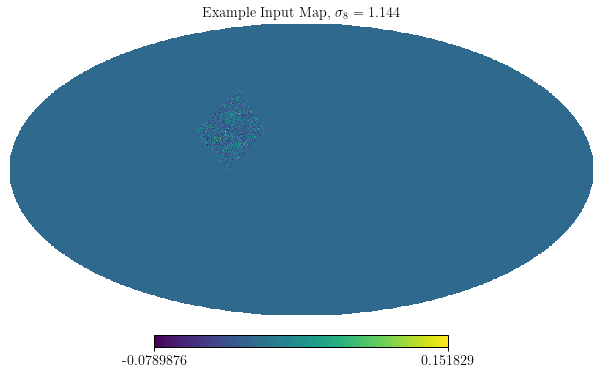

In [52]:
hp.mollview(full_map(ex_input_batch[0,:,0]), nest=True, title="Example Input Map, $\sigma_8=1.144$")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 

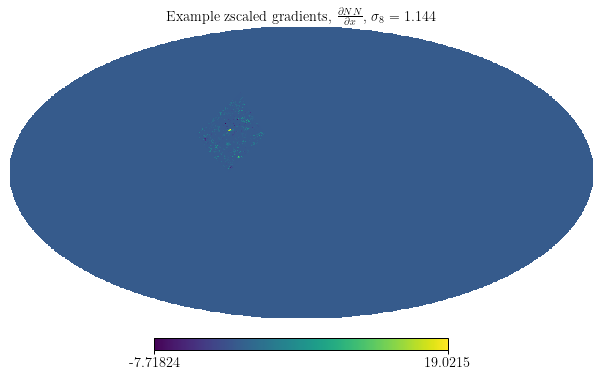

In [62]:
hp.mollview(full_map(ex_zscaled_grads[0,:,0]), nest=True, 
            title=r"Example zscaled gradients, $\frac{\partial NN}{\partial x}$, $\sigma_8=1.144$")

In [63]:
ex_input_x_grads = np.multiply(ex_input_batch, ex_grads)
ex_zscaled_input_x_grads = zscale(ex_input_x_grads)

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


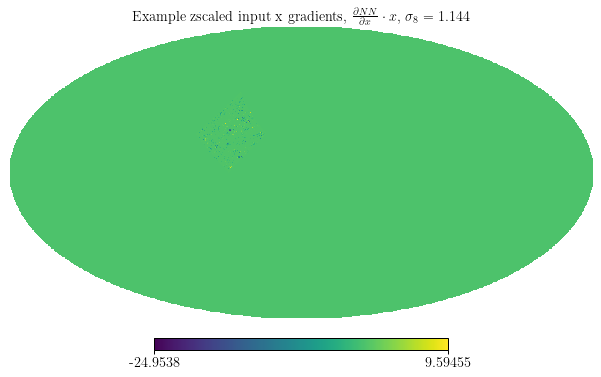

In [64]:
hp.mollview(full_map(ex_zscaled_input_x_grads[0,:,0]), nest=True,
           title=r"Example zscaled input x gradients, $\frac{\partial NN}{\partial x} \cdot x$, $\sigma_8=1.144$")

## Binned saliency scores: example

In [65]:
ex_zscaled_input_map = zscale(ex_input_batch[0])

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [171]:
ex_input_map = ex_input_batch[0]

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
ex_zscaled_input_map

array([[-0.0913625 ],
       [ 0.00816235],
       [ 0.36135749],
       ...,
       [ 0.20887882],
       [-0.1211046 ],
       [-1.49866376]])

In [78]:
ex_zscaled_grads_map = ex_zscaled_grads[0,:,0].numpy()

In [97]:
ex_zscaled_grads_map = np.reshape(ex_zscaled_grads_map, ex_zscaled_input_map.shape)

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
ex_zscaled_grads_map

array([[-0.17578638],
       [-0.17673229],
       [-0.17652449],
       ...,
       [-0.63741   ],
       [-0.67477566],
       [-0.665258  ]], dtype=float32)

In [73]:
ex_zscaled_input_x_grads_map = ex_zscaled_input_x_grads[0,:,0]

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
ex_zscaled_input_x_grads_map = np.reshape(ex_zscaled_input_x_grads_map, ex_zscaled_input_map.shape)

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
ex_zscaled_input_x_grads_map

array([[0.11955785],
       [0.11958438],
       [0.119548  ],
       ...,
       [0.02434701],
       [0.16269212],
       [0.75999144]])

In [70]:
from astropy.visualization import hist

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:4: DeprecationWarning: invalid escape sequence \k
<>:6: DeprecationWarning: invalid escape sequence \s
<ipython-input-84-0a3747efd138>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


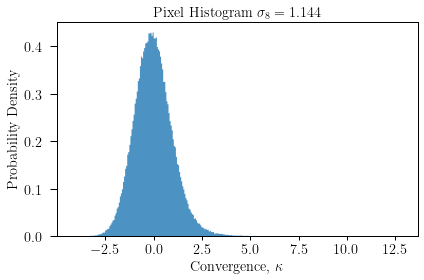

In [84]:
fig, ax = plt.subplots()
hist(ex_zscaled_input_map, bins="scott", ax=ax, histtype="stepfilled", alpha=0.8, density=True)
# ax.set_xlim([-2.5, 2.5])
ax.set_xlabel("Convergence, $\kappa$")
ax.set_ylabel("Probability Density")
ax.set_title("Pixel Histogram $\sigma_8=1.144$")
plt.tight_layout()
fig.show()

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:6: DeprecationWarning: invalid escape sequence \s
<ipython-input-104-8a9aadd55541>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


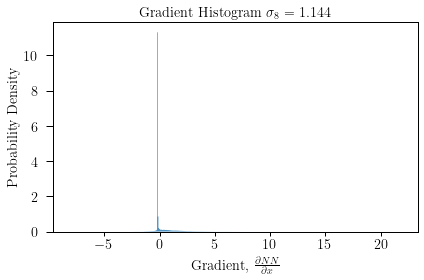

In [104]:
fig, ax = plt.subplots()
hist(ex_zscaled_grads_map, bins="scott", ax=ax, histtype="stepfilled", alpha=0.8, density=True)
# ax.set_xlim([-2.5, 2.5])
ax.set_xlabel(r"Gradient, $\frac{\partial NN}{\partial x}$")
ax.set_ylabel("Probability Density")
ax.set_title("Gradient Histogram $\sigma_8=1.144$")
plt.tight_layout()
fig.show()

<>:6: DeprecationWarning: invalid escape sequence \s


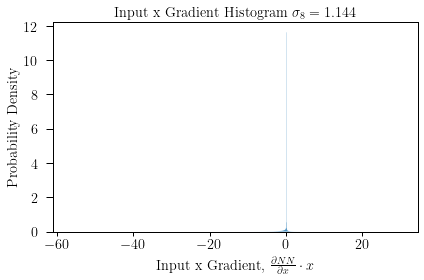

In [102]:
fig, ax = plt.subplots()
hist(ex_zscaled_input_x_grads_map, bins="scott", ax=ax, histtype="stepfilled", alpha=0.8, density=True)
# ax.set_xlim([-2.5, 2.5])
ax.set_xlabel(r"Input x Gradient, $\frac{\partial NN}{\partial x} \cdot x$")
ax.set_ylabel("Probability Density")
ax.set_title("Input x Gradient Histogram $\sigma_8=1.144$")
plt.tight_layout()

In [107]:
from scipy import stats

In [108]:
stats.describe(ex_zscaled_input_map)

DescribeResult(nobs=262144, minmax=(array([-4.1478746]), array([12.7910947])), mean=array([0.]), variance=array([1.00000381]), skewness=array([0.5554876]), kurtosis=array([1.77895625]))

In [134]:
x = np.ones(262144)

In [135]:
x.shape[0]

262144

In [143]:
def square_sum(x):
    return np.sum(np.multiply(x, x))/x.shape[0]

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [148]:
bin_ss_grads = stats.binned_statistic(np.reshape(ex_zscaled_input_map, (262144)),
                       np.reshape(ex_zscaled_grads_map, (262144)), statistic=square_sum, bins=40, range=(-20,20))

In [150]:
bin_mean_grads = stats.binned_statistic(np.reshape(ex_zscaled_input_map, (262144)),
                       np.reshape(ex_zscaled_grads_map, (262144)), statistic='mean', bins=40, range=(-20,20))

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [149]:
bin_ss_input_x_grads = stats.binned_statistic(np.reshape(ex_zscaled_input_map, (262144)),
                       np.reshape(ex_zscaled_input_x_grads_map, (262144)), 
                                           statistic=square_sum, bins=40, range=(-20,20))

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [151]:
bin_mean_input_x_grads = stats.binned_statistic(np.reshape(ex_zscaled_input_map, (262144)),
                       np.reshape(ex_zscaled_input_x_grads_map, (262144)), 
                                           statistic='mean', bins=40, range=(-20,20))

In [152]:
bin_ss_grads

BinnedStatisticResult(statistic=array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        0.3413972 , 13.4141453 ,  6.16986164,  3.51759364,  1.50177791,
        0.47665862,  0.1127574 ,  0.08377422,  0.03099235,  0.03061862,
        0.03096202,  0.03098969,  0.03026482,  0.03038229,  0.03109082,
        0.03111334,  0.03634349,  0.03147375,         nan,         nan,
               nan,         nan,         nan,         nan,         nan]), bin_edges=array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.]), binnumber=array([20, 21, 21, ..., 21, 20, 19]))

In [153]:
bin_mean_grads

BinnedStatisticResult(statistic=array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        0.58429205,  1.89484235,  1.06859418,  0.61277639,  0.21540012,
       -0.04744884, -0.1517069 , -0.16932327, -0.17522083, -0.17402173,
       -0.17556959, -0.17602993, -0.17378548, -0.17423569, -0.17632588,
       -0.17638974, -0.19063969, -0.17740843,         nan,         nan,
               nan,         nan,         nan,         nan,         nan]), bin_edges=array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.]), binnumber=array([20, 21, 21, ..., 21, 20, 19]))

In [154]:
bin_ss_input_x_grads

BinnedStatisticResult(statistic=array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan, 7.11118384e+00,
       1.08279518e+02, 2.66430971e+01, 5.71008272e+00, 4.09137840e-01,
       9.57330237e-02, 1.45865425e-01, 2.23269188e-01, 1.82058655e-02,
       2.19234734e-02, 1.82760822e-02, 1.49079813e-02, 2.15648928e-02,
       1.96705609e-02, 1.44336522e-02, 1.43027450e-02, 5.26927281e-04,
       1.16639926e-02,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan]), bin_edges=array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  1

In [155]:
bin_mean_input_x_grads

BinnedStatisticResult(statistic=array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       -2.6666803 , -5.72126247, -2.39978768, -0.84861048, -0.05966886,
        0.15947249,  0.14777208,  0.13346555,  0.1232944 ,  0.12896103,
        0.12362062,  0.12164575,  0.13697112,  0.13548092,  0.1201389 ,
        0.11959408, -0.0229549 ,  0.10799997,         nan,         nan,
               nan,         nan,         nan,         nan,         nan]), bin_edges=array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.]), binnumber=array([20, 21, 21, ..., 21, 20, 19]))

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \k


Text(0.5, 1.0, 'Average squared scaled gradient by binned r.m.s. $\\kappa$')

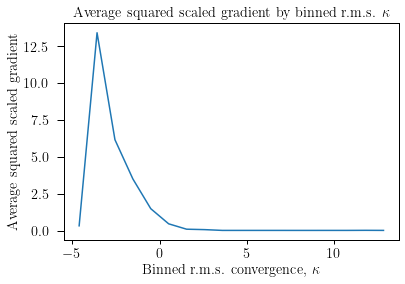

In [167]:
plt.plot(np.linspace(-20, 20, num=40), bin_ss_grads.statistic)
# plt.xticks(np.arange(-20, 20))
plt.xlabel("Binned r.m.s. convergence, $\kappa$")
plt.ylabel("Average squared scaled gradient")
plt.title("Average squared scaled gradient by binned r.m.s. $\kappa$")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \k


Text(0.5, 1.0, 'Average squared scaled input x gradient by binned r.m.s. $\\kappa$')

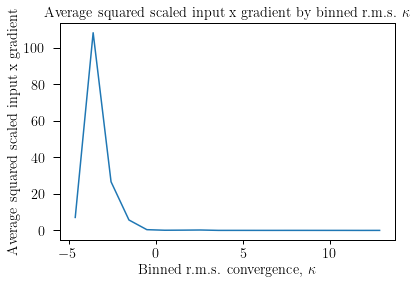

In [168]:
plt.plot(np.linspace(-20, 20, num=40), bin_ss_input_x_grads.statistic)
# plt.xticks(np.arange(-20, 20))
plt.xlabel("Binned r.m.s. convergence, $\kappa$")
plt.ylabel("Average squared scaled input x gradient")
plt.title("Average squared scaled input x gradient by binned r.m.s. $\kappa$")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \k


Text(0.5, 1.0, 'Mean scaled gradient by binned r.m.s. $\\kappa$')

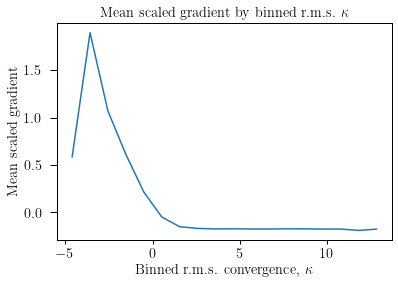

In [169]:
plt.plot(np.linspace(-20, 20, num=40), bin_mean_grads.statistic)
# plt.xticks(np.arange(-20, 20))
plt.xlabel("Binned r.m.s. convergence, $\kappa$")
plt.ylabel("Mean scaled gradient")
plt.title("Mean scaled gradient by binned r.m.s. $\kappa$")

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \k


Text(0.5, 1.0, 'Mean scaled input x gradient by binned r.m.s. $\\kappa$')

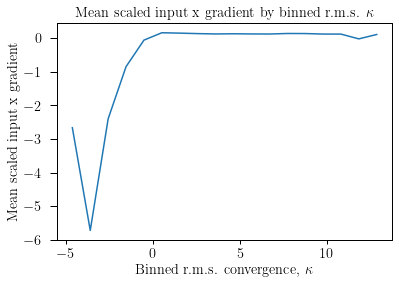

In [170]:
plt.plot(np.linspace(-20, 20, num=40), bin_mean_input_x_grads.statistic)
# plt.xticks(np.arange(-20, 20))
plt.xlabel("Binned r.m.s. convergence, $\kappa$")
plt.ylabel("Mean scaled input x gradient")
plt.title("Mean scaled input x gradient by binned r.m.s. $\kappa$")

In [172]:
stats.describe(ex_input_map)

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DescribeResult(nobs=262144, minmax=(array([-0.10119582]), array([0.31444355])), mean=array([0.0005825]), variance=array([0.00060209]), skewness=array([0.5554876]), kurtosis=array([1.77895625]))

In [173]:
np.mean(ex_input_map)

0.0005825046129199853

In [174]:
np.std(ex_input_map)

0.024537465267773083

## Two-point correlation saliency scores: example

In [175]:
ex_input_map

array([[-0.0016593 ],
       [ 0.00078279],
       [ 0.0094493 ],
       ...,
       [ 0.00570786],
       [-0.0023891 ],
       [-0.03619091]])

In [176]:
ex_zscaled_input_map

array([[-0.0913625 ],
       [ 0.00816235],
       [ 0.36135749],
       ...,
       [ 0.20887882],
       [-0.1211046 ],
       [-1.49866376]])

In [180]:
ex_zscaled_grads_map

array([[-0.17578638],
       [-0.17673229],
       [-0.17652449],
       ...,
       [-0.63741   ],
       [-0.67477566],
       [-0.665258  ]], dtype=float32)

In [181]:
ex_zscaled_input_x_grads_map

array([[0.11955785],
       [0.11958438],
       [0.119548  ],
       ...,
       [0.02434701],
       [0.16269212],
       [0.75999144]])

In [182]:
import treecorr

In [185]:
pixel_dec = np.pi/2 - hp.pix2ang(nside, 
                                 np.arange(hp.nside2npix(nside)))[0]

In [186]:
pixel_ra = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))[1]

In [187]:
empty_map = np.zeros(hp.nside2npix(nside))

In [190]:
ex_map_ring = hp.reorder(full_map(ex_input_map[:,0]), n2r=True)

In [191]:
ex_map_catalogue = treecorr.Catalog(ra=pixel_ra, dec=pixel_dec, ra_units='rad', dec_units='rad',
                                      k=ex_map_ring)

In [192]:
sampled = np.zeros((nside//order)**2)

In [193]:
import random

In [194]:
hp.nside2resol(nside, arcmin=True)

3.435486411817406

In [195]:
hp.nside2resol(order, arcmin=True)

1758.9690428505119

In [197]:
def new_sample():
    pixel_index = random.randint(0, (nside//order)**2 - 1)
    while sampled[pixel_index] == 1:
        pixel_index = random.randint(0, (nside//order)**2 - 1)
    sampled[pixel_index] = 1
    print("Sampling index ", pixel_index)
    
    empty_map[hp.nest2ring(nside, pixel_index)] = ex_input_map[pixel_index, 0]
    print("Generating catalogue")
    empty_map_catalogue = treecorr.Catalog(ra=pixel_ra, dec=pixel_dec, ra_units='rad', dec_units='rad',
                                      k=empty_map)
    
    print("Computing correlation")
    kk = treecorr.KKCorrelation(min_sep=5, max_sep=1750, nbins=120, sep_units='arcmin')
    kk.process(ex_map_catalogue, empty_map_catalogue)
    kk.write("2pcf.txt")

In [198]:
new_sample()

Sampling index  135521
Generating catalogue
Computing correlation


In [ ]:
with open("dummy.txt", "r") as f:
    xi = float(f.readlines()[-1].split()[3])

In [203]:
hp.query_disc(1024, hp.pix2vec(1024, hp.nest2ring(1024, 135521)), 5*np.pi/(60*180)).shape

(7,)

In [300]:
def two_pcf_saliency_estimate(index, radius, bin_width=3.5):
    pixel_set = hp.query_disc(nside, hp.pix2vec(nside, hp.nest2ring(nside, index)), radius*np.pi/(60*180)).shape
    small_set = hp.query_disc(nside, hp.pix2vec(nside, hp.nest2ring(nside, index)),
                              (radius-bin_width)*np.pi/(60*180)).shape
    annular_set = np.setdiff1d(pixel_set, small_set)
    nnxi = ex_grads.numpy()[0,index,0]
    fxi = np.sum(full_map(np.reshape(ex_input_map, (262144)))[annular_set])
    if fxi == 0:
        return np.inf
    return (nside//order)**2 * nnxi / fxi

In [232]:
two_pcf_saliency_estimate(135531, 10)

array([5.23165958])

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


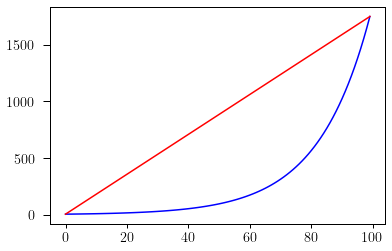

In [216]:
plt.plot(np.arange(100), np.geomspace(5, 1750, num=100), 'b-', np.arange(100), np.linspace(5, 1750, num=100), 'r-')

In [233]:
%timeit two_pcf_saliency_estimate(100, 1500)

<ipython-input-231-bb4da62a448e>:6: RuntimeWarning: divide by zero encountered in true_divide
  return (nside//order)**2 * ex_grads.numpy()[0,index,0] / (ex_input_map[index] * np.sum(full_map(np.reshape(ex_input_map, (262144)))[annular_set]))


27.4 ms ± 998 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [304]:
# Linearly spaced bin values

num_lin_bins = 150
pixel_freq = 1000
lin_saliencies = np.zeros((num_lin_bins, (nside//order)**2))

period = 10000

for n, r in zip(np.arange(num_lin_bins), np.linspace(5, 1750, num=num_lin_bins)):
    for i in range(0, (nside//order)**2, pixel_freq):
        if i % period == 0: print("n: ", n, "r: ", r, "i: ", i, end="\r")
        lin_saliencies[n, i] = two_pcf_saliency_estimate(i, r)

In [332]:
valid_saliencies = []
for i in range(num_lin_bins):
    valid_saliencies.append([])
    for j in np.where(lin_saliencies[i] != np.inf)[0]:
        valid_saliencies[i].append(lin_saliencies[i,j])
    valid_saliencies[i] = np.array(valid_saliencies[i])

In [335]:
valid_saliencies

[array([0.07914753, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([-0.21691615,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]),
 array([0.2440602, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]),
 array([0.23032169, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([-0.62847459,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]),
 array([-5.91865012,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]),
 array([0.17078175, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([-0.07511977,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]),
 array([-1.40286448,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]),
 array([-0.70586576,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]),
 array([-0.13518721,

In [336]:
mean_valid_saliencies = [np.mean(valid_saliencies[i]) for i in range(num_lin_bins)]

Text(0.5, 1.0, 'Mean single-pixel saliency estimates for $\\xi(r)$, $N=262$')

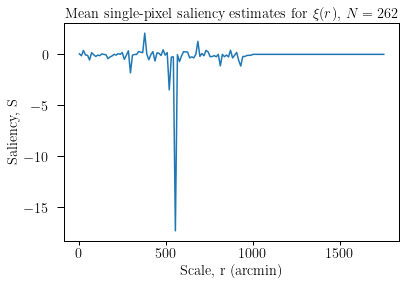

In [337]:
plt.plot(np.linspace(5, 1750, num=num_lin_bins), mean_valid_saliencies)
plt.xlabel("Scale, r (arcmin)")
plt.ylabel("Saliency, S")
plt.title(r"Mean single-pixel saliency estimates for $\xi(r)$, $N=262$")

In [338]:
for n, r in zip(np.arange(num_lin_bins), np.linspace(5, 1750, num=num_lin_bins)):
    print(n, r)

0 5.0
1 16.711409395973156
2 28.42281879194631
3 40.13422818791946
4 51.84563758389262
5 63.557046979865774
6 75.26845637583892
7 86.97986577181209
8 98.69127516778524
9 110.40268456375838
10 122.11409395973155
11 133.8255033557047
12 145.53691275167785
13 157.248322147651
14 168.95973154362417
15 180.6711409395973
16 192.38255033557047
17 204.09395973154363
18 215.80536912751677
19 227.51677852348993
20 239.2281879194631
21 250.93959731543623
22 262.6510067114094
23 274.36241610738256
24 286.0738255033557
25 297.7852348993289
26 309.496644295302
27 321.20805369127515
28 332.91946308724835
29 344.6308724832215
30 356.3422818791946
31 368.0536912751678
32 379.76510067114094
33 391.4765100671141
34 403.18791946308727
35 414.8993288590604
36 426.61073825503354
37 438.32214765100673
38 450.03355704697987
39 461.744966442953
40 473.4563758389262
41 485.1677852348993
42 496.87919463087246
43 508.59060402684565
44 520.3020134228188
45 532.0134228187919
46 543.7248322147651
47 555.436241610738

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [339]:
stats.describe(valid_saliencies[49])

DescribeResult(nobs=262144, minmax=(-116589.17257982, 3589.158503983586), mean=-0.7065481707953705, variance=57511.267433865534, skewness=-447.3804721056899, kurtosis=214047.6599873882)

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Single-Pixel Saliency Histogram $\\sigma_8=1.144$, $n=1$, $r=578.86$')

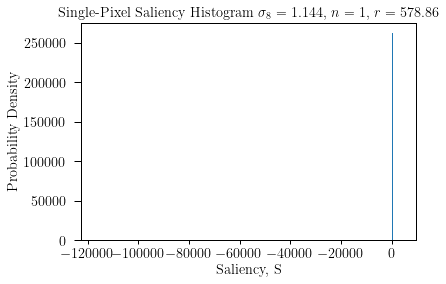

In [341]:
fig, ax = plt.subplots()
# hist(lin_saliencies[49,:], bins="scott", ax=ax, histtype="stepfilled", density=True)
ax.hist(valid_saliencies[49], bins=200)
# ax.set_xlim([-2.5, 2.5])
ax.set_xlabel("Saliency, S")
ax.set_ylabel("Probability Density")
ax.set_title(r"Single-Pixel Saliency Histogram $\sigma_8=1.144$, $n=1$, $r=578.86$")

In [342]:
from scipy.special import comb

average_saliencies = []

k = 262
n = 50
m = 10000
M = comb(k, n)
m = min(m, M)

for i in range(m):
    pixel_set = np.random.choice(valid_saliencies[49], (n), replace=False)
    average_saliencies.append(np.mean(pixel_set))

In [343]:
average_saliencies

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 31.249462421575355,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.44060866076060246,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0001496608211036289,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.5664397122919836,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.005978731554543744,
 0.0004824670501103356,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -20.598420701766262,
 0.0,
 0.0,
 0.0,
 0.0,

Text(0.5, 1.0, 'Multi-Pixel Saliency Histogram $\\sigma_8=1.144$, $n=20$, $r=578.86$')

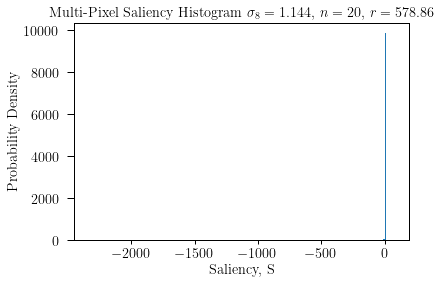

In [344]:
fig, ax = plt.subplots()
# hist(lin_saliencies[49,:], bins="scott", ax=ax, histtype="stepfilled", density=True)
ax.hist(average_saliencies, bins=200)
# ax.set_xlim([-2.5, 2.5])
ax.set_xlabel("Saliency, S")
ax.set_ylabel("Probability Density")
ax.set_title(r"Multi-Pixel Saliency Histogram $\sigma_8=1.144$, $n=20$, $r=578.86$")

Text(0.5, 1.0, 'Multi-Pixel Saliency Histogram $\\sigma_8=1.144$, $n=10$, $r=578.86$')

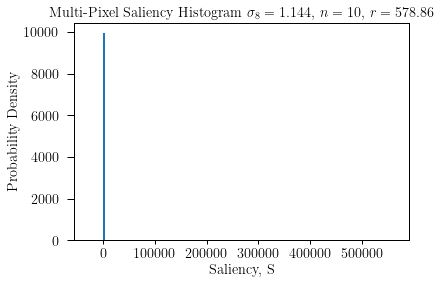

In [280]:
fig, ax = plt.subplots()
# hist(lin_saliencies[49,:], bins="scott", ax=ax, histtype="stepfilled", density=True)
ax.hist(average_saliencies, bins=200)
# ax.set_xlim([-2.5, 2.5])
ax.set_xlabel("Saliency, S")
ax.set_ylabel("Probability Density")
ax.set_title(r"Multi-Pixel Saliency Histogram $\sigma_8=1.144$, $n=10$, $r=578.86$")

In [289]:
def bin_score_averages(b, n):
    average_saliencies = []

    k = 262
    m = 10000
    M = comb(k, n)
    m = min(m, M)

    for i in range(m):
        pixel_set = np.random.choice(lin_saliencies[b,:], (n), replace=False)
        average_saliencies.append(np.mean(pixel_set))
        
    print(stats.describe(average_saliencies))
    
    fig, ax = plt.subplots()
    # hist(lin_saliencies[49,:], bins="scott", ax=ax, histtype="stepfilled", density=True)
    ax.hist(average_saliencies, bins=200)
    # ax.set_xlim([-2.5, 2.5])
    ax.set_xlabel("Saliency, S")
    ax.set_ylabel("Probability Density")
    ax.set_title(r"Multi-Pixel Saliency Histogram $\sigma_8=1.144$, $n={0}$, $r={1}$".format(n, 
                                                                                             np.linspace(5, 1750, num=num_lin_bins)[b]))
    fig.show()

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DescribeResult(nobs=10000, minmax=(-152885.89447914198, 13556.22006949968), mean=-22.420962475788834, variance=2877981.776070579, skewness=-76.94444939358932, kurtosis=6696.326182579379)


<ipython-input-289-c4b0a00dcbc3>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


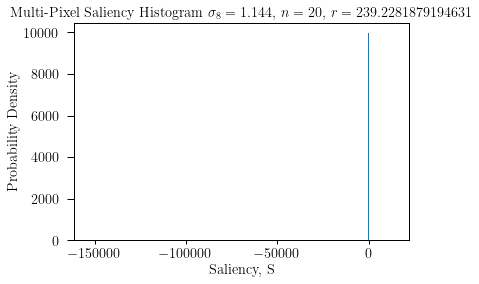

In [290]:
bin_score_averages(20, 20)

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: supplied range of [-inf, inf] is not finite

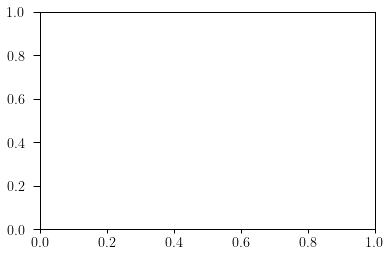

In [283]:
bin_score_averages(109, 2)

In [285]:
stats.describe(lin_saliencies[109,:])

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


DescribeResult(nobs=262144, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)

In [286]:
lin_saliencies[109,:]

array([-inf,   0.,   0., ...,   0.,   0.,   0.])

In [291]:
test_saliencies = np.zeros((1260, 150, 262144))

/Users/adiraju/opt/anaconda3/envs/deep_dss/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [294]:
data["x"]

array([[[-1.65929959e-03],
        [ 7.82788031e-04],
        [ 9.44930153e-03],
        ...,
        [ 5.70786150e-03],
        [-2.38909538e-03],
        [-3.61909054e-02]],

       [[ 9.94611983e-03],
        [-2.10067405e-02],
        [ 5.46006369e-03],
        ...,
        [ 2.74920947e-02],
        [-2.39905094e-02],
        [-2.42284657e-02]],

       [[-7.33043447e-05],
        [-9.23569536e-03],
        [ 1.36337009e-02],
        ...,
        [-2.72086534e-02],
        [ 3.78101485e-02],
        [ 3.55047457e-02]],

       ...,

       [[-2.73681035e-02],
        [-1.64409155e-02],
        [ 3.41649524e-03],
        ...,
        [-1.63902315e-02],
        [ 2.34717244e-02],
        [-8.37349210e-03]],

       [[ 3.51648520e-02],
        [-6.21866365e-04],
        [ 1.84427045e-02],
        ...,
        [ 1.12847699e-02],
        [-3.91138551e-02],
        [-6.51720826e-03]],

       [[-4.74043557e-02],
        [ 4.13512266e-02],
        [-2.66142821e-02],
        ...,
        

In [ ]:
def two_pcf_saliency_estimate(index, radius, bin_width=3.5):
    pixel_set = hp.query_disc(nside, hp.pix2vec(nside, hp.nest2ring(nside, index)), radius*np.pi/(60*180)).shape
    small_set = hp.query_disc(nside, hp.pix2vec(nside, hp.nest2ring(nside, index)),
                              (radius-bin_width)*np.pi/(60*180)).shape
    annular_set = np.setdiff1d(pixel_set, small_set)
    nnxi = ex_grads.numpy()[0,index,0]
    fxi = ex_input_map[index] * np.sum(full_map(np.reshape(ex_input_map, (262144)))[annular_set])
    if fxi == 0:
        return np.inf
    return (nside//order)**2 * nnxi / fxi

In [299]:
for i in range(21):
    print("On cosmology", i)
    input_batch = tf.convert_to_tensor(data["x"][i*48:(i+1)*48], dtype=tf.float32)
    label_batch = tf.convert_to_tensor(data["y"][i*48:(i+1)*48], dtype=tf.float32)
    
    print("Computing gradients")
    with tf.GradientTape() as tape:
        tape.watch(input_batch)
        output = model(input_batch)
        loss = loss_function(label_batch, output)
        
    grads = tape.gradient(loss, input_batch)
    
    for j in range(48):
        print("On map", j)
        for n, r in zip(np.arange(num_lin_bins), np.linspace(5, 1750, num=num_lin_bins)):
            for k in range(0, (nside//order)**2, pixel_freq):
                if k % period == 0: print("n: ", n, "r: ", r, "k: ", k, end="\r")
                pixel_set = hp.query_disc(nside, hp.pix2vec(nside, hp.nest2ring(nside, k)), r*np.pi/(60*180)).shape
                small_set = hp.query_disc(nside, hp.pix2vec(nside, hp.nest2ring(nside, k)),
                                          (r-3.5)*np.pi/(60*180)).shape
                annular_set = np.setdiff1d(pixel_set, small_set)
                nnxi = grads.numpy()[i*48+j,k,0]
                fxi = data["x"][i*48+j,k,0] * np.sum(full_map(np.reshape(data["x"][i*48+j], (262144)))[annular_set])
                if fxi == 0:
                    test_saliencies[i*48+j,n,k] = np.inf
                else:
                    test_saliencies[i*48+j,n,k] = (nside//order)**2 * nnxi / fxi


On cosmology 0
Computing gradients
On map 0
On map 1r:  1750.0 k:  260000 k:  2600000
On map 2r:  1750.0 k:  260000 k:  2600000


KeyboardInterrupt: 